In [1]:
import geopandas as gpd
import rasterio
from rasterio import features
import matplotlib.pyplot as plt
from rasterio.plot import show
import numpy as np
import os

In [4]:
def soilmap_from_puhti(soilmap, subset, out_fd, ref_raster, soildepth='surface', plot=True, save_in='geotiff'):
    '''
    Soilmap 20
    1: Kalliomaa, 2: Sora, 3: Hiekkamoreeni, 4: Hiekka, 
    5: karkea Hieta , 6: hieno Hieta, 7: Hiesu, 8: Saraturve, 9: Rahkaturve, 10: Vesi
    Soilmap 200
    1: Kalliomaa, 2: Kalliopaljastuma, 3: Karkearakeinen maalaji, 4: Sekalajitteinen maalaji ,
    5: Hienojakoinen maalaji, 6: Soistuma, 7: Ohut turvekerros, 8: Paksu turvekerros, 9: Vesi
    '''
    if soilmap == 200:
        soilfile = r'/projappl/project_2000908/geodata/soil/mp200k_maalajit.shp'
    elif soilmap == 20:
        soilfile = r'/projappl/project_2000908/geodata/soil/mp20k_maalajit.shp'

    if not os.path.exists(out_fd):
        # Create a new directory because it does not exist
        os.makedirs(out_fd)
    
    mpk = {}
    if soilmap == 20:
        mpk[195111.0] = 1 # Kalliomaa
        mpk[195313.0] = 2 # Sora
        mpk[195214.0] = 3 # Hiekkamoreeni
        mpk[195314.0] = 4 # Hiekka
        mpk[195315.0] = 5 # karkea Hieta 
        mpk[195411.0] = 6 # hieno Hieta
        mpk[195412.0] = 7 # Hiesu
        mpk[195512.0] = 8 # Saraturve
        mpk[195513.0] = 9 # Rahkaturve
        mpk[195603.0] = 10 # Vesi
    elif soilmap == 200:
        mpk = {}
        mpk[195111.0] = 1 # Kalliomaa
        mpk[195110.0] = 2 # Kalliopaljastuma
        mpk[195310.0] = 3 # Karkearakeinen maalaji
        mpk[195210.0] = 4 # Sekalajitteinen maalaji 
        mpk[195410.0] = 5 # Hienojakoinen maalaji
        mpk[19551822.0] = 6 # Soistuma
        mpk[19551891.0] = 7 # Ohut turvekerros
        mpk[19551892.0] = 8 # Paksu turvekerros
        mpk[195603.0] = 9 # Vesi

    soil = gpd.read_file(soilfile, include_fields=["PINTAMAALA", "PINTAMAA_1", "POHJAMAALA", "POHJAMAA_1", "geometry"], bbox=new_subset)
    soil.PINTAMAALA = soil.PINTAMAALA.astype("float64")
    soil.POHJAMAALA = soil.POHJAMAALA.astype("float64")
    
    if save_in == 'geotiff':
        out_fn = os.path.join(out_fd, f'{soildepth}{soilmap}') + '.tif'
    elif save_in == 'asc':
        out_fn = os.path.join(out_fd, f'{soildepth}{soilmap}') + '.asc'

    rst = rasterio.open(ref_raster)
    meta = rst.meta.copy()
    meta.update(compress='lzw')
    if save_in == 'geotiff':
        meta.update({"driver": "GTiff"})        
    elif save_in == 'asc':
        meta.update({"driver": "AAIGrid"})
        
    with rasterio.open(out_fn, 'w+', **meta) as out:
        out_arr = out.read(1)

        # this is where we create a generator of geom, value pairs to use in rasterizing
        if soildepth=='surface':
            shapes = ((geom,value) for geom, value in zip(soil.geometry, soil.PINTAMAALA))
        if soildepth=='bottom':
            shapes = ((geom,value) for geom, value in zip(soil.geometry, soil.POHJAMAALA))

        burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform)
        burned[burned == 0] = -9999
        for key in mpk.keys():
            burned[burned == key] = mpk[key]
        out.write_band(1, burned)

In [12]:
mp = 20 # maalajit 20 or 200?

if mp == 200:
    soilfile = r'/projappl/project_2000908/geodata/soil/mp200k_maalajit.shp'
elif mp == 20:
    soilfile = r'/projappl/project_2000908/geodata/soil/mp20k_maalajit.shp'

new_subset = [350016.0, 6858072.0, 357856.0, 6864536.0]
out_fd = r'/scratch/project_2000908/nousu/GISPUTS/Kuivalake_Catchment/GIS_inputs/kuivajarvi/soil/'
ref_raster = r'/scratch/project_2000908/nousu/GISPUTS/Kuivalake_Catchment/GIS_inputs/kuivajarvi/cmask_d8_kuivajarvi_fill.asc'

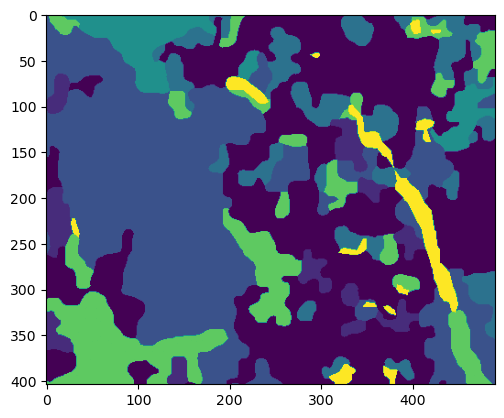

In [5]:
new_subset = [350016.0, 6858072.0, 357856.0, 6864536.0]
out_fd = r'/scratch/project_2000908/nousu/GISPUTS/Kuivalake_Catchment/GIS_inputs/kuivajarvi/soil/'
ref_raster = r'/scratch/project_2000908/nousu/GISPUTS/Kuivalake_Catchment/GIS_inputs/kuivajarvi/cmask_d8_kuivajarvi_fill.asc'

soilmap_from_puhti(soilmap=200, subset=new_subset, out_fd=out_fd, ref_raster=ref_raster, soildepth='bottom', plot=True, save_in='asc')

In [3]:
mpk = {}
if mp == 20:
    mpk[195111.0] = 1 # Kalliomaa
    mpk[195313.0] = 2 # Sora
    mpk[195214.0] = 3 # Hiekkamoreeni
    mpk[195314.0] = 4 # Hiekka
    mpk[195315.0] = 5 # karkea Hieta 
    mpk[195411.0] = 6 # hieno Hieta
    mpk[195412.0] = 7 # Hiesu
    mpk[195512.0] = 8 # Saraturve
    mpk[195513.0] = 9 # Rahkaturve
    mpk[195603.0] = 10 # Vesi
elif mp == 200:
    mpk = {}
    mpk[195111.0] = 1 # Kalliomaa
    mpk[195110.0] = 2 # Kalliopaljastuma
    mpk[195310.0] = 3 # Karkearakeinen maalaji
    mpk[195210.0] = 4 # Sekalajitteinen maalaji 
    mpk[195410.0] = 5 # Hienojakoinen maalaji
    mpk[19551822.0] = 6 # Soistuma
    mpk[19551891.0] = 7 # Ohut turvekerros
    mpk[19551892.0] = 8 # Paksu turvekerros
    mpk[195603.0] = 9 # Vesi

In [13]:
soil = gpd.read_file(soilfile, include_fields=["PINTAMAALA", "PINTAMAA_1", "POHJAMAALA", "POHJAMAA_1", "geometry"], bbox=new_subset)
soil.PINTAMAALA = soil.PINTAMAALA.astype("float64")
soil.POHJAMAALA = soil.POHJAMAALA.astype("float64")

In [14]:
soil.POHJAMAALA.unique();
soil.POHJAMAA_1.unique()

array(['Saraturve (Ct) RT', 'hieno Hieta (HHt) RT', 'Hiekka (Hk) RT',
       'karkea Hieta (KHt) RT', 'Hiesu (Hs) RT', 'Kalliomaa (Ka) RT',
       'Hiekkamoreeni (Mr) RT', 'Sora (Sr) RT', 'Rahkaturve (St) RT',
       'Vesi (Ve)'], dtype=object)

In [4]:
rst_fn = r'/scratch/project_2000908/nousu/GISPUTS/Kuivalake_Catchment/GIS_inputs/kuivajarvi/cmask_d8_kuivajarvi_fill.asc'
if mp == 200:
    out_fn = r'/scratch/project_2000908/nousu/GISPUTS/Kuivalake_Catchment/GIS_inputs/kuivajarvi/pintamaa200.asc'
elif mp == 20:
    out_fn = r'/scratch/project_2000908/nousu/GISPUTS/Kuivalake_Catchment/GIS_inputs/kuivajarvi/pintamaa20.asc'

In [6]:
rst = rasterio.open(rst_fn)
meta = rst.meta.copy()
meta.update(compress='lzw')

In [7]:
with rasterio.open(out_fn, 'w+', **meta) as out:
    out_arr = out.read(1)

    # this is where we create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom,value) for geom, value in zip(soil.geometry, soil.PINTAMAALA))

    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform)
    burned[burned == 0] = -9999
    for key in mpk.keys():
        burned[burned == key] = mpk[key]
    out.write_band(1, burned)

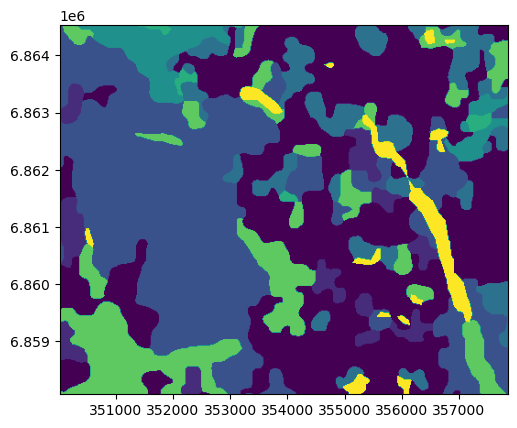

<Axes: >

In [8]:
test = rasterio.open(out_fn)
show(test)

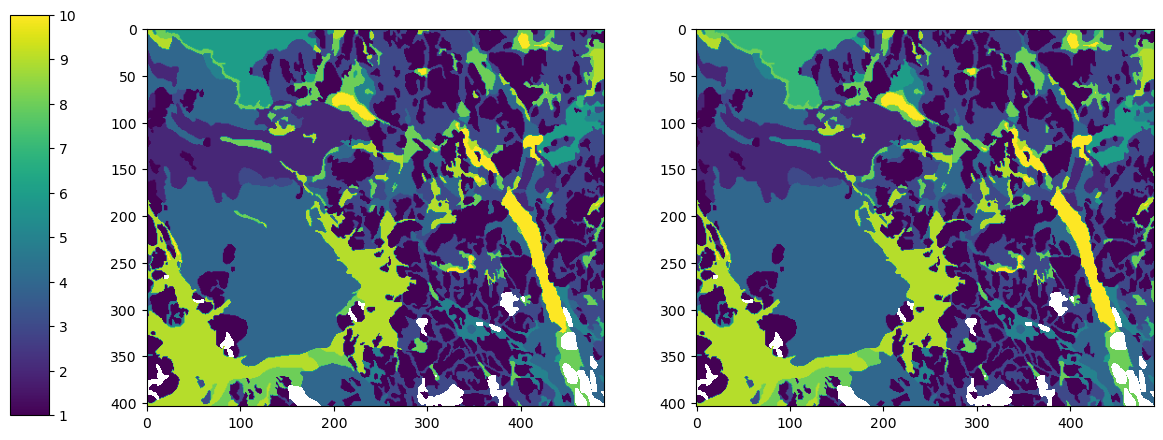

In [6]:
from tools import read_AsciiGrid
out_fn1 = r'/scratch/project_2000908/nousu/GISPUTS/Kuivalake_Catchment/GIS_inputs/kuivajarvi/soil/pintamaa20.asc'
test1 = read_AsciiGrid(out_fn1)[0]

out_fn2 = r'/scratch/project_2000908/nousu/GISPUTS/Kuivalake_Catchment/GIS_inputs/kuivajarvi/soil/pohjamaa20.asc'
test2 = read_AsciiGrid(out_fn2)[0]

fig = plt.figure(figsize=(13,5))
ax1 = plt.subplot(1,2,1)
im1 = ax1.imshow(test1, vmin=1, vmax=10);

ax2 = plt.subplot(1,2,2)
im2 = ax2.imshow(test2, vmin=1, vmax=10);
cbar_ax = fig.add_axes([0.02, 0.1, 0.03, 0.8])
fig.colorbar(im1, cax=cbar_ax)

In [16]:
# combining 200 and 20 actually not easy because the numbers do not correspond
fn1 = r'/scratch/project_2000908/nousu/GISPUTS/Kuivalake_Catchment/GIS_inputs/kuivajarvi/soil/surface20.asc'
fn2 = r'/scratch/project_2000908/nousu/GISPUTS/Kuivalake_Catchment/GIS_inputs/kuivajarvi/soil/surface200.asc'

data1 = rasterio.open(fn1)
data2 = rasterio.open(fn2)

arr1 = data1.read(1)
arr2 = data2.read(1)

arr1[arr1 == -9999] = arr2[arr1 == -9999]

out_meta = data1.meta.copy()

In [17]:
arr1[arr1 == -9999] = arr2[arr1 == -9999]

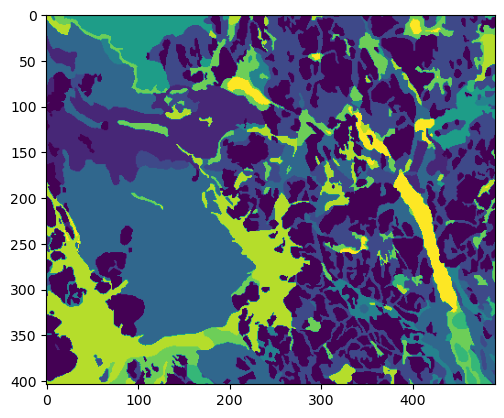

In [18]:
plt.imshow(arr1)

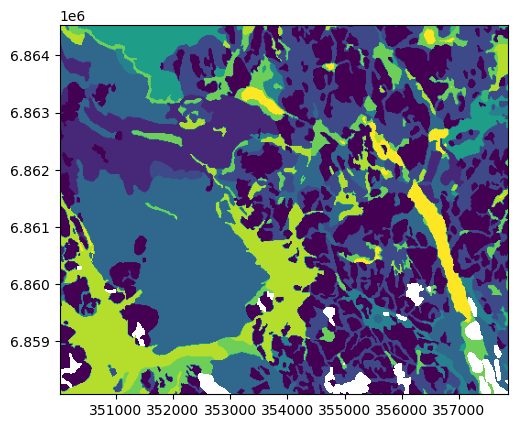

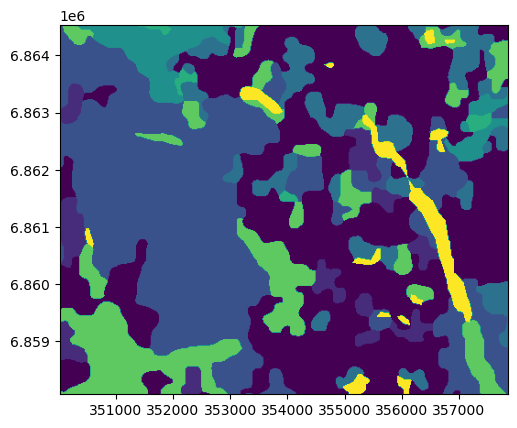

<Axes: >

In [22]:
out_fn1 = r'/scratch/project_2000908/nousu/GISPUTS/Kuivalake_Catchment/GIS_inputs/kuivajarvi/soil/pintamaa20.tif'
test1 = rasterio.open(out_fn1)
show(test1)

out_fn2 = r'/scratch/project_2000908/nousu/GISPUTS/Kuivalake_Catchment/GIS_inputs/kuivajarvi/soil/pintamaa200.tif'
test2 = rasterio.open(out_fn2)
show(test2)

#fig = plt.figure(figsize=(13,5))
#ax1 = plt.subplot(1,2,1)
#im1 = ax1.imshow(test1, vmin=1, vmax=10);

#ax2 = plt.subplot(1,2,2)
#im2 = ax2.imshow(test2, vmin=1, vmax=10);
#cbar_ax = fig.add_axes([0.02, 0.1, 0.03, 0.8])
#fig.colorbar(im1, cax=cbar_ax)